In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataset_tools import *

In [3]:

l = [i for i in open('/media/hpc2_storage/nvaulin/test_ties32/list.txt') if i.find('PTZ') < 0]
f = open('/media/hpc2_storage/nvaulin/test_ties32/list.txt','w')
for i in l:
    f.write(i)
    
f.close()

In [3]:
def get_motion_ties(img,_mask,t_size):
    mask = np.zeros_like(_mask,dtype=np.float32)
    mask[_mask > 240] = 1
    c = np.cumsum(mask,0)
    c = np.cumsum(c,1)
    mask = (c[t_size:,t_size:] + c[:-t_size,:-t_size] - c[:-t_size,t_size:] - c[t_size:,:-t_size])/(t_size**2)
    h = w = t_size//2
    cols = mask.shape[1]//w
    rows = mask.shape[0]//h
    mask = mask[:h*rows,:w*cols]
    x_inx = np.arange(mask.shape[1])[None,:]+mask*0
    y_inx = np.arange(mask.shape[0])[:,None]+mask*0
    mask = np.transpose(mask.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w)
    y_inx = np.transpose(y_inx.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w).astype(np.int32)
    x_inx = np.transpose(x_inx.reshape((rows,h,cols,w)),(0,2,1,3)).reshape(cols*rows,h*w).astype(np.int32)
    res = []
    for i in np.arange(len(mask))[mask.max(1) > 0.95]:
        inx = mask[i].argmax()
        x = x_inx[i][inx]
        y = y_inx[i][inx]
        res.append(img[y:y+t_size,x:x+t_size])
    return np.array(res)

def get_motion_batch(imgs,masks,t_size):
    res = np.empty((0,t_size,t_size,3),dtype=np.uint8)
    for i in range(len(imgs)):
        tmp = get_motion_ties(imgs[i],masks[i],t_size)
        if(len(tmp) > 0):
            res = np.concatenate((res,tmp),axis=0)
    return res

def process_batch(out_dir,imgs,masks,w,h,min_r,min_roi):
    cols = imgs.shape[2]//w
    rows = imgs.shape[1]//h
    imgs = imgs[:,:h*rows,:w*cols,:]
    masks = masks[:,:h*rows,:w*cols]
    imgs = np.transpose(imgs.reshape((-1,rows,h,cols,w,3)),(1,3,0,2,4,5)).reshape(cols*rows,len(imgs),h,w,3)
    masks = np.transpose(masks.reshape((-1,rows,h,cols,w)),(1,3,0,2,4)).reshape(cols*rows,len(masks),h,w)
    motion = np.zeros_like(masks)
    motion[masks > 240] = 1
    motion = motion.mean((2,3))

    roi = np.zeros_like(masks)
    roi[(masks > 240) | (masks < 10)] = 1
    roi = roi.mean((2,3))
    iter = 0
    for i in range(len(masks)):
        if(motion[i].mean() >= min_r and roi[i].mean() >= min_roi):
            cv2.imwrite(out_dir+'/%d_input.jpg'%(iter),ties_to_image(imgs[i]))
            cv2.imwrite(out_dir+'/%d_mask.png'%(iter),ties_to_image(masks[i]))
            iter+=1
    return imgs.reshape((-1,h,w,3))[motion.flatten()>=.97],iter

def save_motion(out_dir,motion_ties):
    if not (motion_ties is None):
        for i in range(int(np.ceil(float(len(motion_ties))/50.))):
            im = ties_to_image(motion_ties[i*50:min((i+1)*50,len(motion_ties))],5,10)
            cv2.imwrite(out_dir+'/%d_motion.jpg'%(i),im)
        return len(motion_ties)
    else:
        return 0

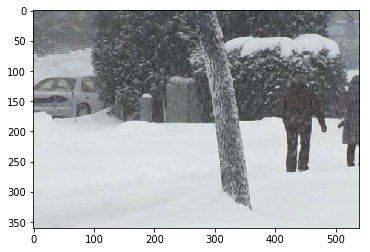

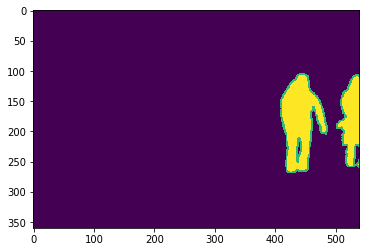

In [65]:
im = cv2.imread('../gmm_segmentation/dataset/badWeather/skating/input/in001001.jpg')
mask = cv2.imread('../gmm_segmentation/dataset/badWeather/skating/groundtruth/gt001001.png',0)
plt.imshow(im)
plt.show()
plt.imshow(mask)
plt.show()

In [67]:
res = get_motion_ties(im,mask,32)
print res.shape
res = res.reshape((-1,5*32,32,3))

(415, 127)
(422, 127)
(415, 138)
(421, 128)
(412, 144)
(416, 144)
(415, 160)
(416, 160)
(415, 176)
(419, 176)
(10, 32, 32, 3)


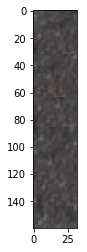

In [68]:
plt.imshow(res[0])
plt.show()

In [5]:
def generate_ties(dataset,out_dir,length,tie_size,min_r=0,min_roi = 0.5):
    for video_num,(in_dir,out_dir) in enumerate(iterate_folders(dataset,out_dir)):
        ties_num = 0
        motion_ties = None
        for batch_num,(imgs,masks) in enumerate(iterate_bathced(in_dir,length)):
            _,i = process_batch(out_dir,imgs,masks,tie_size,tie_size,min_r,min_roi)
            ties_num += i
            m_ties = get_motion_batch(imgs,masks,tie_size)
            if(len(m_ties) > 0):
                if not(motion_ties is None):
                    motion_ties = np.concatenate((motion_ties,m_ties))
                else:
                    motion_ties = m_ties
        print out_dir+ ' %d ties=%d motion=%d'%(batch_num,ties_num,save_motion(out_dir,motion_ties))

In [6]:
generate_ties('../gmm_segmentation/dataset','tties32',256,32,-1.,0.95)

tties32/badWeather/skating 11 ties=1049 motion=31653
tties32/badWeather/snowFall 21 ties=3616 motion=23413
tties32/badWeather/wetSnow 10 ties=1334 motion=11720
tties32/baseline/office 4 ties=318 motion=10541
tties32/baseline/pedestrians 2 ties=227 motion=1
tties32/baseline/PETS2006 2 ties=1156 motion=4895
tties32/cameraJitter/boulevard 5 ties=346 motion=11826
tties32/cameraJitter/sidewalk 0 ties=17 motion=97
tties32/cameraJitter/traffic 1 ties=118 motion=5027
tties32/dynamicBackground/canoe 0 ties=51 motion=35
tties32/dynamicBackground/fall 10 ties=3627 motion=51930
tties32/dynamicBackground/fountain01 2 ties=326 motion=0
tties32/dynamicBackground/fountain02 2 ties=351 motion=0
tties32/dynamicBackground/overpass 6 ties=434 motion=2755
tties32/intermittentObjectMotion/parking 4 ties=0 motion=0
tties32/intermittentObjectMotion/sofa 7 ties=482 motion=4323
tties32/intermittentObjectMotion/streetLight 10 ties=10 motion=0
tties32/intermittentObjectMotion/tramstop 6 ties=4 motion=212
tties32/

In [7]:
generate_ties('../gmm_segmentation/test_dataset','test_tties32',256,32,-1.,0.95)

test_tties32/badWeather/blizzard 22 ties=3599 motion=26583
test_tties32/baseline/highway 3 ties=219 motion=5636
test_tties32/cameraJitter/badminton 0 ties=298 motion=3239
test_tties32/dynamicBackground/boats 22 ties=676 motion=0
test_tties32/intermittentObjectMotion/abandonedBox 7 ties=16 motion=0
test_tties32/lowFramerate/port_0_17fps 6 ties=363 motion=0
test_tties32/nightVideos/bridgeEntry 4 ties=62 motion=0
test_tties32/PTZ/continuousPan 3 ties=660 motion=3741
test_tties32/shadow/backdoor 5 ties=301 motion=1215
test_tties32/thermal/corridor 18 ties=1239 motion=20073
test_tties32/turbulence/turbulence0 14 ties=2309 motion=0


In [16]:
import shutil
def purge(dir):
    for i in os.listdir(dir):
        for j in os.listdir(dir+'/'+i):
            p = dir+'/'+i+'/'+j
            l = [k[:-4] for k in os.listdir(p)]
            if( not('0_motion' in l)):
                print(p,'no motion ',len(l))
                shutil.rmtree(p)
            else:
                print(p,len(l))
purge('/media/hpc2_storage/nvaulin/ties32')        
purge('/media/hpc2_storage/nvaulin/test_ties32')           

('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence2', 'no motion ', 360)
('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence3', 683)
('/media/hpc2_storage/nvaulin/ties32/turbulence/turbulence1', 661)
('/media/hpc2_storage/nvaulin/ties32/thermal/lakeSide', 139)
('/media/hpc2_storage/nvaulin/ties32/thermal/park', 199)
('/media/hpc2_storage/nvaulin/ties32/thermal/diningRoom', 225)
('/media/hpc2_storage/nvaulin/ties32/thermal/library', 524)
('/media/hpc2_storage/nvaulin/ties32/PTZ/zoomInZoomOut', 'no motion ', 136)
('/media/hpc2_storage/nvaulin/ties32/PTZ/twoPositionPTZCam', 123)
('/media/hpc2_storage/nvaulin/ties32/PTZ/intermittentPan', 384)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/overpass', 136)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/fall', 898)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/canoe', 'no motion ', 102)
('/media/hpc2_storage/nvaulin/ties32/dynamicBackground/fountain02', 'no motion ', 234)
('/media/hpc2_storage/nvaulin/t